In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np
import tqdm
import pandas as pd
from cluster_algorithm import cluster_algorithm
import pickle
import os

## Data Loading
**Sources**:
* [Native Token transfers](https://github.com/hop-protocol/hop-airdrop/tree/master/src/data/transfers/nativeTokenTransfers)
* [Hop transfers](https://github.com/hop-protocol/hop-airdrop/tree/master/src/data/transfers/hopTransfers)
* [ERC20Token Transfers](https://github.com/hop-protocol/hop-airdrop/tree/master/src/data/transfers/erc20TokenTransfers) (not used yet)

For each Data set ```cluster_algorithm.py``` is ran. Partition, connected_members_list and G_nx are saved in the ```cache``` folder

In [14]:
# Load the transaction data for native token transfers

def load_or_cache(data_file, cache_file, func, *args):
    if os.path.exists(cache_file):
        print(f"Using cached information for {data_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    else:
        print(f"Processing {data_file}...")
        result = func(*args)
        with open(cache_file, 'wb') as f:
            pickle.dump(result, f)
        return result


# Define cache files
cache_files = {
    "ethereum": "cache/ethereum_nativeTokenTransfers.pkl",
    "polygon": "cache/polygon_nativeTokenTransfers.pkl",
    "optimism": "cache/optimism_nativeTokenTransfers.pkl",
    "xdai": "cache/xdai_nativeTokenTransfers.pkl",
    "arbitrum": "cache/arbitrum_nativeTokenTransfers.pkl"
}


# Load and process data
results = {}
for network, cache_file in cache_files.items():
    data_file = f"data/{network}_nativeTokenTransfers.csv"
    transactions_df = pd.read_csv(data_file)
    transactions_df[['from', 'to']] = transactions_df[['from', 'to']].apply(lambda x: '0' + x)
    
    # Cluster using Leiden
    partition, connected_members_list, G_nx = load_or_cache(
        data_file, 
        cache_file, 
        cluster_algorithm, 
        transactions_df
    )
    
    # Store results in dictionary
    results[network] = {
        'partition': partition,
        'connected_members_list': connected_members_list,
        'G_nx': G_nx
    }

Processing data/ethereum_nativeTokenTransfers.csv...
Accounts before filtering:  397444 
Accounts after filtering blacklisted:  140914


100%|████████████████████████████████████████████████████████████████████████████████| 718/718 [05:14<00:00,  2.28it/s]


Lenght:  23160
Processing data/polygon_nativeTokenTransfers.csv...
Accounts before filtering:  310447 
Accounts after filtering blacklisted:  167326


100%|████████████████████████████████████████████████████████████████████████████████| 945/945 [11:07<00:00,  1.42it/s]


Lenght:  44259
Processing data/optimism_nativeTokenTransfers.csv...
Accounts before filtering:  12507 
Accounts after filtering blacklisted:  9828


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 72.41it/s]


Lenght:  742
Processing data/xdai_nativeTokenTransfers.csv...
Accounts before filtering:  45721 
Accounts after filtering blacklisted:  35675


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:09<00:00, 20.65it/s]


Lenght:  7017
Processing data/arbitrum_nativeTokenTransfers.csv...
Accounts before filtering:  214602 
Accounts after filtering blacklisted:  214602


100%|████████████████████████████████████████████████████████████████████████████████| 708/708 [18:25<00:00,  1.56s/it]


Lenght:  57094


In [107]:
# Load the transaction data for Hop transfers

cache_file = "hop_transfers_cache.pkl"

# Check if cache exists
if os.path.exists(cache_file):
    # Load from cache
    with open(cache_file, 'rb') as f:
        partition_HopTransfers, connected_members_list_HopTransfers, HopTransfers = pickle.load(f)
        print("Loaded from cache.")
else:
    # Load transaction data
    transactions_HopTransfers = pd.read_csv("data/all_hop_transfers.csv")
    
    # Cluster using Leiden
    partition_HopTransfers, connected_members_list_HopTransfers, HopTransfers = cluster_algorithm(transactions_HopTransfers)
    
    # Save to cache
    with open(cache_file, 'wb') as f:
        pickle.dump((partition_HopTransfers, connected_members_list_HopTransfers, HopTransfers), f)
        print("Cached results.")

Accounts before filtering:  473838 
Accounts after filtering blacklisted:  473838


100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [04:32<00:00,  2.01s/it]


Lenght:  8153
Cached results.


## Data
**Transfers**:

Hop Transnfers (DAI, ETH, MATIC, USDC, USDT) = ```all_hop_transfers.csv```

Native Token Transfers =
    "ethereum": ```ethereum_nativeTokenTransfers.csv```,
    "polygon": ```polygon_nativeTokenTransfers.csv```,
    "optimism": ```optimism_nativeTokenTransfers.csv```,
    "xdai": ```xdai_nativeTokenTransfers.csv```,
    "arbitrum": ```arbitrum_nativeTokenTransfers.csv```


**Sybil information**:

initial elegible addresses = ```initial_elegible_accounts.csv``` len(32805)

final elegible addresses = ```final_elegible_accounts.csv``` len(28857)

github issue sybil addreses reported = ```reported_addresses``` len(4313)

eliminated sybil attackers from Hop = ```eliminatedSybilAttackers``` len(14195) Contains Issue reported addresses

In [106]:
transactions_df_HopTransfers

# Load Ethereum transactions and blacklist
elegible_airdrop_accounts = pd.read_csv('data/initial_elegible_accounts.csv')
reported_sybil_accounts = pd.read_csv('data/reported_addresses.csv')
eliminated_sybil_attackers = pd.read_csv('data/eliminatedSybilAttackers.csv')

# Merge connected members lists
nativeTokenTransfers_members = set()
for network in results:
    nativeTokenTransfers_members = nativeTokenTransfers_members.union(set(results[network]['connected_members_list']))

elegible_native_token_transfers = set(nativeTokenTransfers_members) & set(elegible_airdrop_accounts['address'].values)
elegible_hop_transfers = set(nativeTokenTransfers_members) & set(connected_members_list_HopTransfers)

all_sybil_accounts = set(eliminated_sybil_attackers['address']).union(set(reported_sybil_accounts['address']))

print("sybil detected from Hop transfers: ", len(elegible_hop_transfers))
matched_hop = elegible_hop_transfers & all_sybil_accounts
print("matched Hop transfers from report:", len(matched_hop))
print("-------------")
print("sybil detected from Native token transfers: ", len(nativeTokenTransfers_members))
matched_native_token = nativeTokenTransfers_members & all_sybil_accounts
print("matched Native token transfers from report:", len(matched_native_token))


sybil detected from Hop transfers:  1083
matched Hop transfers from report: 153
-------------
sybil detected from Native token transfers:  124481
matched Native token transfers from report: 3640


## Plot

In [6]:
# Identify unique communities and assign colors
unique_communities = list(set(partition_ethHopTransfers.values()))
colors = plt.cm.tab20.colors  

# Filter communities with 20+ members
large_communities = [community for community in unique_communities 
                     if len([node for node, comm in partition_ethHopTransfers.items() if comm == community]) >= 20]

community_colors = {community: colors[i % len(colors)] for i, community in enumerate(large_communities)}

# Set up cluster centers for each community to reduce overlap
cluster_centers = {community: (np.cos(2 * np.pi * i / len(large_communities)) * 5,
                               np.sin(2 * np.pi * i / len(large_communities)) * 5)
                   for i, community in enumerate(large_communities)}


In [7]:
# Initialize positions dictionary
pos = {}

# Arrange each community around its cluster center
for community_id, center in cluster_centers.items():
    community_nodes = [node for node, comm in partition_ethHopTransfers.items() if comm == community_id]
    subgraph = G_nx_ethHopTransfers.subgraph(community_nodes)
    community_pos = nx.spring_layout(subgraph, seed=42, k=0.2, scale=1.0)
    community_pos = {node: (coord[0] + center[0], coord[1] + center[1]) for node, coord in community_pos.items()}
    pos.update(community_pos)

KeyError: '0x7d5fda35a5f885a286da02ccc2fa4614eb3842da'

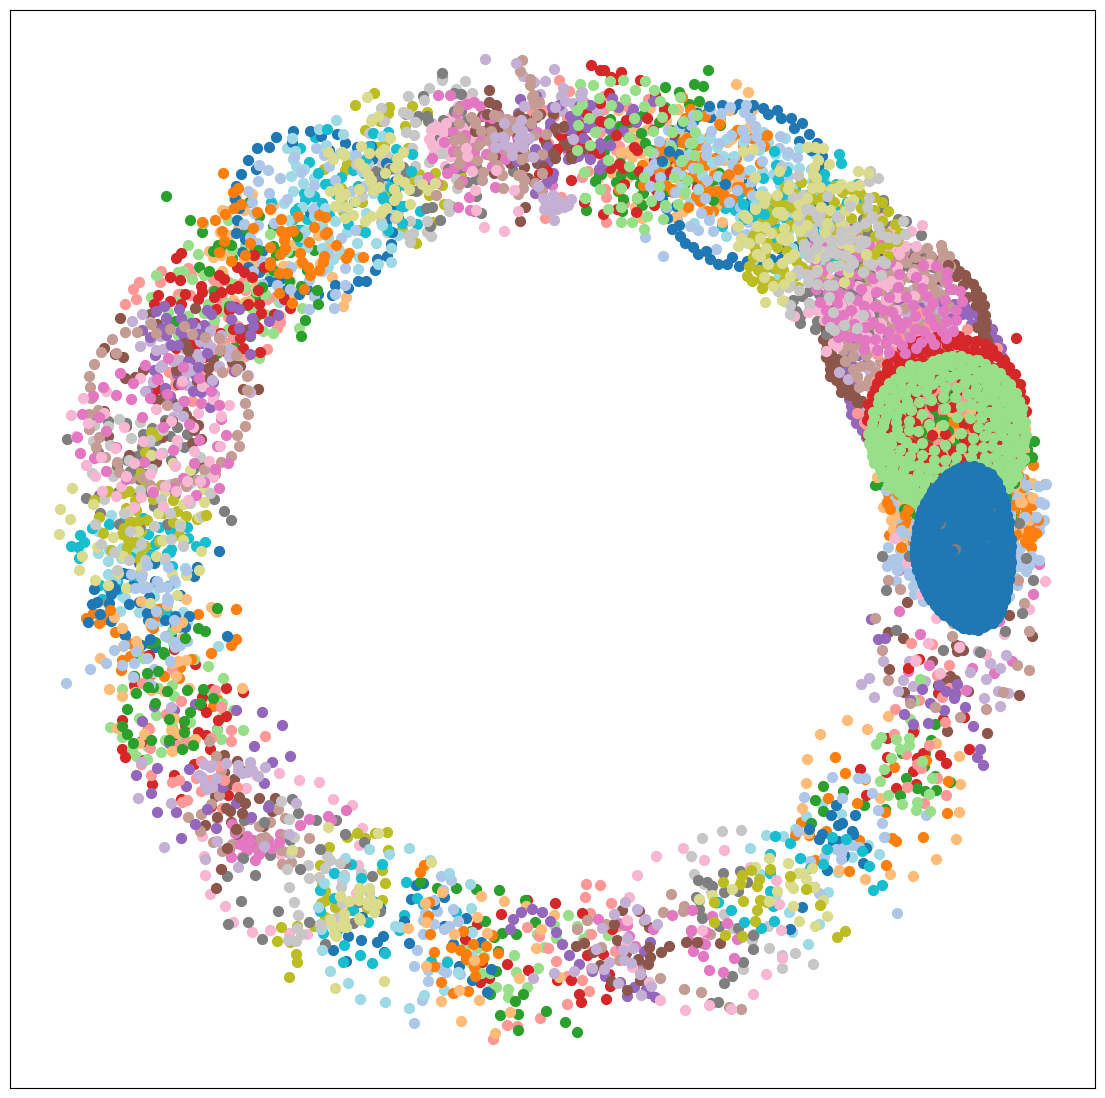

In [8]:
# Plot communities with 20+ members
plt.figure(figsize=(14, 14))

# Draw nodes with colors based on their community
for node, community_id in partition_ethHopTransfers.items():
    if community_id in large_communities:
        nx.draw_networkx_nodes(G_nx_ethHopTransfers, pos, nodelist=[node], node_size=50, node_color=[community_colors[community_id]])

# Draw edges with arrows and reduced alpha
nx.draw_networkx_edges(G_nx_ethHopTransfers, pos, edge_color="gray", alpha=0.5, arrows=True)

# Show the plot
plt.title("Leiden Community Detection on Transaction Network with Separate Clusters")
plt.savefig("images/Leiden.png", format='png')  
plt.show()